# Data Preparation for Machine Learning

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,StandardScaler, Normalizer, Binarizer,LabelEncoder,OneHotEncoder,KBinsDiscretizer
from sklearn.metrics import r2_score, accuracy_score
import datetime

In [478]:
#!pip install yellowbrick
#!pip install mlxtend

# Data Cleaning

## 1) Automobile Dataset

Predict the mpg based on the other features

In [51]:
cars = pd.read_csv("cars.csv")
cars.shape

(394, 12)

In [52]:
cars.head()

,Model,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,bore,stroke,compression-ratio
0,chevrolet chevelle malibu,18.0,8,307,130,3504,12,1970[1975],"US; Detroit, Michigan",3.47,2.68,9
1,buick skylark 320,15.0,8,350,165,3693,11.5,1970,US],3.47,2.68,?
2,plymouth satellite,18.0,?,318,150,3436,11,"1970, 1976",US,2.68,3.47,9
3,amc rebel sst,16.0,8,304,150,3433,12,1970,US,3.19,3.40,10
4,ford torino,17.0,8,302,140,3449,10.5,1970-1972,US],3.19,3.40,8


### Data Cleaning

In [53]:
# Replace the question marks with NAN
cars.replace("?",np.nan,inplace = True)

In [54]:
# Check for total null values
cars.isnull().sum().sum()

16

In [55]:
# Check for nulls by column
cars.isnull().sum()

Model                0
MPG                  9
Cylinders            2
Displacement         1
Horsepower           0
Weight               1
Acceleration         1
Year                 0
Origin               0
bore                 0
stroke               0
compression-ratio    2
dtype: int64

In [56]:
# Fill null values in MPG with the mean of the column (can also just use dropna())
cars["MPG"] = cars["MPG"].fillna(cars["MPG"].mean())
cars["MPG"].isna().sum()

0

In [57]:
# Drop the missing values in the other columns
cars = cars.dropna()

In [58]:
cars.shape

(387, 12)

In [59]:
# Remove unecessary columns
cars.drop(columns = ["Model","bore","stroke","compression-ratio"],axis = 1,inplace = True)

In [60]:
cars.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin
0,18.000000,8,307,130,3504,12,1970[1975],"US; Detroit, Michigan"
3,16.000000,8,304,150,3433,12,1970,US
4,17.000000,8,302,140,3449,10.5,1970-1972,US]
6,14.000000,8,454,220,4354,9,1970[1975],"US; Detroit, Michigan"
7,23.551429,8,440,215,4312,8.5,1970,US


In [61]:
# Clean up the Year Column - find how many values are numeric
cars["Year"].str.isnumeric().value_counts()

True     351
False     36
Name: Year, dtype: int64

In [62]:
# Look at the non-numeric values
cars[cars["Year"].str.isnumeric() == False].head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin
0,18.000000,8,307,130,3504,12,1970[1975],"US; Detroit, Michigan"
4,17.000000,8,302,140,3449,10.5,1970-1972,US]
6,14.000000,8,454,220,4354,9,1970[1975],"US; Detroit, Michigan"
30,23.551429,4,140,90,2264,15.5,1971[1973]971,"US; Detroit, Michigan"
35,19.000000,6,250,88,3302,15.5,1971[1973],US


In [63]:
# Strip out the first four characters to be the year and put into a new column
cars["year"] = cars['Year'].str[:4]
cars.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,year
0,18.000000,8,307,130,3504,12,1970[1975],"US; Detroit, Michigan",1970
3,16.000000,8,304,150,3433,12,1970,US,1970
4,17.000000,8,302,140,3449,10.5,1970-1972,US],1970
6,14.000000,8,454,220,4354,9,1970[1975],"US; Detroit, Michigan",1970
7,23.551429,8,440,215,4312,8.5,1970,US,1970


In [64]:
# Reset the Year column to the new value and set to numeric. Drop the unwanted column
cars["Year"] = pd.to_numeric(cars["year"])
cars.drop(["year"],axis = 1, inplace = True)

In [65]:
# Translate the year to get car age
cars["Age"] = datetime.datetime.now().year - cars["Year"]
cars.drop(columns = "Year", axis = 1, inplace = True)

In [66]:
cars.sample(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Origin,Age
18,27.0,4,97,88,2130,14.5,Japan; Aichi,51
52,31.0,4,71,65,1773,19,Japan; Aichi,50


In [67]:
# Check data types of the rest of the columns - identify objects
cars.dtypes

MPG             float64
Cylinders        object
Displacement     object
Horsepower        int64
Weight           object
Acceleration     object
Origin           object
Age               int64
dtype: object

In [68]:
# Transform to numeric
cars["Cylinders"].str.isnumeric().value_counts()

True     378
False      9
Name: Cylinders, dtype: int64

In [69]:
#Have a look at rows where the datatype is not numeric
cars[cars["Cylinders"].str.isnumeric()==False].head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Origin,Age
11,14.0,-,340,160,3609,8,US,51
22,25.0,-,104,95,2375,17.5,Europe,51


In [70]:
# Find all the non dash items and get the mean
cylinders = cars["Cylinders"].loc[cars["Cylinders"]!= "-"]
mean_cylinder = cylinders.astype(int).mean()
cars["Cylinders"] = cars["Cylinders"].replace("-",mean_cylinder).astype(int)

In [71]:
# Check the displacement column for non-numerics
cars["Displacement"].str.isnumeric().value_counts()

True     386
False      1
Name: Displacement, dtype: int64

In [72]:
# Look at the non-numeric column
cars[cars["Displacement"].str.isnumeric()==False].head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Origin,Age
57,25.0,4,97.5,80,2126,17,US,49


In [73]:
# Change to numeric the rest of the columns shown as object
cars["Displacement"] = pd.to_numeric(cars["Displacement"], errors = 'coerce')
cars["Weight"] = pd.to_numeric(cars["Weight"],errors = 'coerce')
cars["Acceleration"] = pd.to_numeric(cars["Acceleration"],errors = 'coerce')

In [74]:
# Check datatypes
cars.dtypes

MPG             float64
Cylinders         int32
Displacement    float64
Horsepower        int64
Weight            int64
Acceleration    float64
Origin           object
Age               int64
dtype: object

In [75]:
# Look at the origin column
cars["Origin"].unique()

array(['US; Detroit, Michigan', 'US', 'US]', 'Japan; Aichi',
       'Europe-Germany', 'Europe', 'Japan; Tokyo', 'Japan; Aichi]',
       'US; Detroit, Michigan]', 'Japan; Tokyo]', 'Japan',
       'Europe Germany'], dtype=object)

In [76]:
# Just choose the country values
cars["Origin"] = np.where(cars["Origin"].str.contains('US'),'US',cars["Origin"])
cars["Origin"] = np.where(cars["Origin"].str.contains('Japan'),'Japan',cars["Origin"])
cars["Origin"] = np.where(cars["Origin"].str.contains('Europe'),'Europe',cars["Origin"])

In [77]:
cars.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Age
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,23.672514,5.410853,192.184755,103.645995,2965.387597,15.573643,44.917313
std,7.736579,1.667795,103.703706,38.128651,846.332848,2.746260,3.668715
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,39.000000
25%,17.600000,4.000000,102.500000,75.000000,2221.500000,13.900000,42.000000
50%,23.200000,4.000000,146.000000,92.000000,2790.000000,15.500000,45.000000
75%,29.000000,6.000000,260.000000,121.000000,3589.500000,17.050000,48.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,51.000000


### Visualisation of relationships

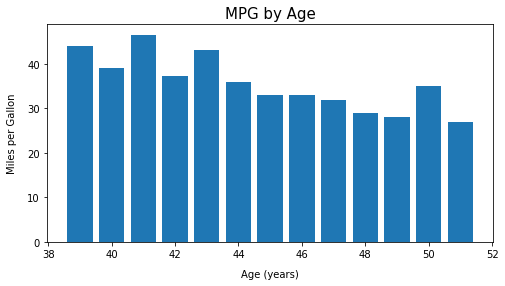

In [78]:
# Age against miles per gallon
fig, ax = plt.subplots(figsize = (8,4))
ax.bar(cars["Age"],cars["MPG"])
ax.set_title("MPG by Age",fontsize = 15)
ax.set_xlabel("Age (years)",fontsize = 10,labelpad = 10)
ax.set_ylabel("Miles per Gallon",fontsize = 10, labelpad = 10)
plt.show()

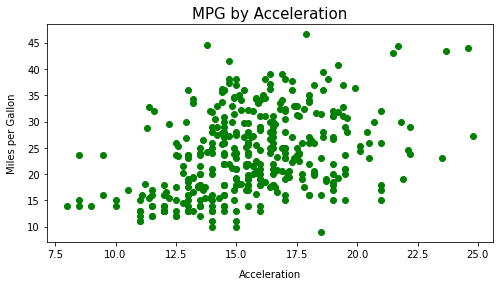

In [79]:
# Acceleration against miles per gallon
fig, ax = plt.subplots(figsize = (8,4))
ax.scatter(cars["Acceleration"],cars["MPG"], color = "g")
ax.set_title("MPG by Acceleration",fontsize = 15)
ax.set_xlabel("Acceleration",fontsize = 10,labelpad = 10)
ax.set_ylabel("Miles per Gallon",fontsize = 10, labelpad = 10)
plt.show()

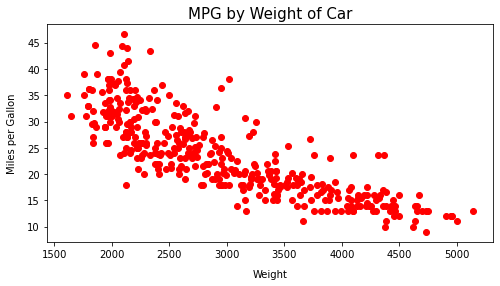

In [80]:
# Weight against miles per gallon
fig, ax = plt.subplots(figsize = (8,4))
ax.scatter(cars["Weight"],cars["MPG"], color = "r")
ax.set_title("MPG by Weight of Car",fontsize = 15)
ax.set_xlabel("Weight",fontsize = 10,labelpad = 10)
ax.set_ylabel("Miles per Gallon",fontsize = 10, labelpad = 10)
plt.show()

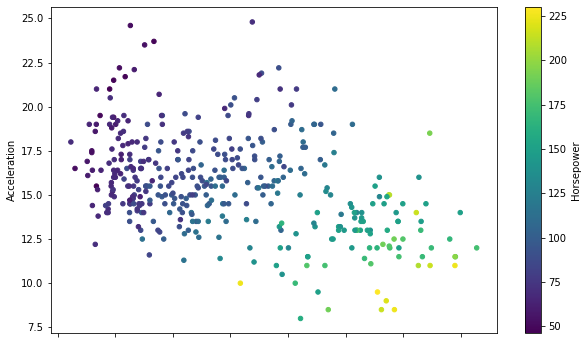

In [81]:
cars.plot.scatter(x = "Weight", y = "Acceleration", c = "Horsepower", colormap = 'viridis', figsize = (10,6))
plt.show()

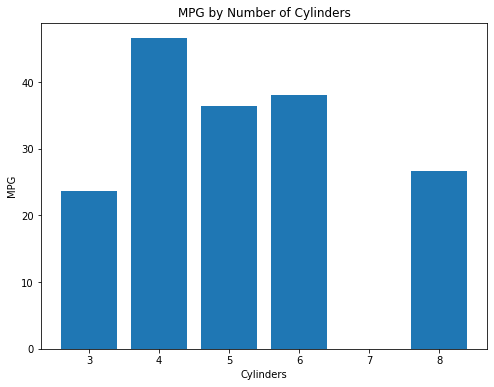

In [82]:
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(cars["Cylinders"], cars["MPG"])
ax.set_title("MPG by Number of Cylinders")
ax.set_xlabel("Cylinders")
ax.set_ylabel("MPG")
plt.show()

In [83]:
# Correlation for the non-discrete variables
cars_dropped = cars.drop(columns = ["Origin","Cylinders"], axis = 1)
cars_dropped.corr()

,MPG,Displacement,Horsepower,Weight,Acceleration,Age
MPG,1.000000,-0.788492,-0.761499,-0.820138,0.392186,-0.566242
Displacement,-0.788492,1.000000,0.894199,0.932822,-0.526901,0.357047
Horsepower,-0.761499,0.894199,1.000000,0.863388,-0.670920,0.404458
Weight,-0.820138,0.932822,0.863388,1.000000,-0.397181,0.299049
Acceleration,0.392186,-0.526901,-0.670920,-0.397181,1.000000,-0.292705
Age,-0.566242,0.357047,0.404458,0.299049,-0.292705,1.000000


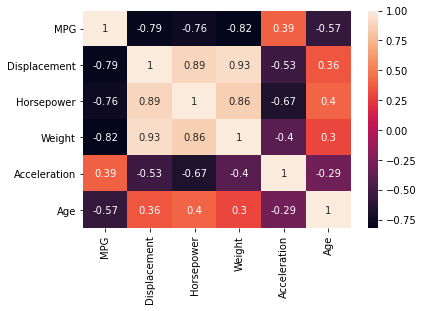

In [84]:
sns.heatmap(cars_dropped.corr(), annot = True)
plt.show()

### Simple Linear Regression Model

In [85]:
# Simple one variable regression - Age
X = cars[["Age"]]
y = cars["MPG"]

In [86]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(309, 1) (78, 1) (309,) (78,)


In [87]:
# Normalize data to centralise the data around a mean of zero, then fit model
model = LinearRegression(normalize = True).fit(X_train, y_train)

In [88]:
# R-squared value (how much of the variation in mpg can be explained by age)
print(model.score(X_train, y_train))

0.3133567150846205


In [89]:
# Get predicted values from the model and then the r squared value for the predicted values against the actual values
y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))

0.340761424059871


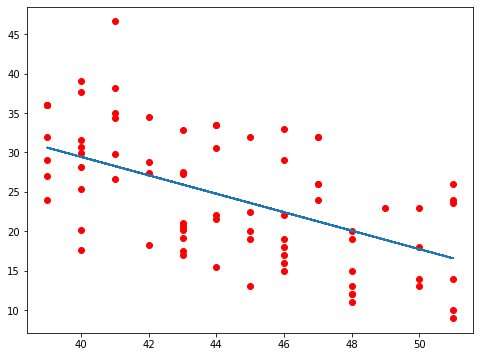

In [90]:
# plot the y_test and y_pred against X_test values
fig, ax = plt.subplots (figsize = (8,6))
ax.scatter(X_test, y_test, color = "r")
plt.plot(X_test, y_pred)
plt.show()

(309, 1) (78, 1) (309,) (78,)
0.5761078923935236
0.598123427638275


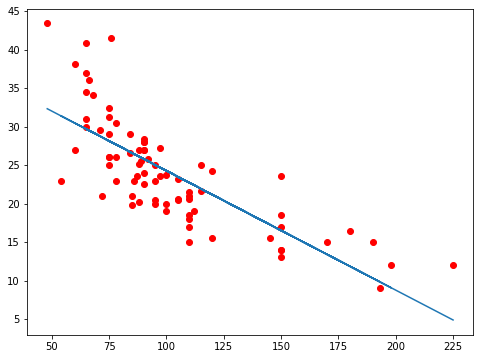

In [91]:
# Simple one variable regression - Horsepower
X = cars[["Horsepower"]]
y = cars["MPG"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = LinearRegression(normalize = True).fit(X_train, y_train)
print(model.score(X_train, y_train))
y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))
fig, ax = plt.subplots (figsize = (8,6))
ax.scatter(X_test, y_test, color = "r")
plt.plot(X_test, y_pred)
plt.show()

## Multiple Regression Model

In [92]:
cars = pd.get_dummies(cars, columns = ["Origin"])
cars.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Age,Origin_Europe,Origin_Japan,Origin_US
0,18.000000,8,307.0,130,3504,12.0,51,0,0,1
3,16.000000,8,304.0,150,3433,12.0,51,0,0,1
4,17.000000,8,302.0,140,3449,10.5,51,0,0,1
6,14.000000,8,454.0,220,4354,9.0,51,0,0,1
7,23.551429,8,440.0,215,4312,8.5,51,0,0,1


In [93]:
# Simple one variable regression - Horsepower
X = cars.drop(columns = ["MPG"],axis = 1)
y = cars["MPG"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
model = LinearRegression(normalize = True).fit(X_train, y_train)
print("Training score",model.score(X_train, y_train))
y_pred = model.predict(X_test)
print("Test score",r2_score(y_test, y_pred))

Training score 0.8033411252163649
Test score 0.796970588479456


## 2) Diabetes Dataset

In [159]:
diabetes = pd.read_csv("diabetes.csv")

In [160]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [161]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [162]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Missing Values Techniques

In [163]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [164]:
# Missing values are shown as zeros in this dataset. Replace with nans
diabetes["Glucose"].replace(0,np.nan,inplace = True)
diabetes["BloodPressure"].replace(0,np.nan,inplace = True)
diabetes["SkinThickness"].replace(0,np.nan,inplace = True)
diabetes["Insulin"].replace(0,np.nan,inplace = True)
diabetes["BMI"].replace(0,np.nan,inplace = True)

In [165]:
# Recheck the missing values
diabetes.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [166]:
# Reshape one columns as an array and replace the nan values as the most frequent value (can also use mean, median etc on numerical)
skin = diabetes["SkinThickness"].values.reshape(-1,1)
imp = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
imp.fit(diabetes["SkinThickness"].values.reshape(-1,1))
diabetes["SkinThickness"] = imp.transform(diabetes["SkinThickness"].values.reshape(-1,1))

In [167]:
# Use median for the glucose field
imp = SimpleImputer(missing_values = np.nan, strategy = "median")
imp.fit(diabetes["Glucose"].values.reshape(-1,1))
diabetes["Glucose"] = imp.transform(diabetes["Glucose"].values.reshape(-1,1))

In [168]:
# Use mean for the glucose field
imp = SimpleImputer(missing_values = np.nan, strategy = "mean")
imp.fit(diabetes["BloodPressure"].values.reshape(-1,1))
diabetes["BloodPressure"] = imp.transform(diabetes["BloodPressure"].values.reshape(-1,1))

In [169]:
# Use constant for the BMI values
imp = SimpleImputer(missing_values = np.nan, strategy = "constant",fill_value = 32)
imp.fit(diabetes["BMI"].values.reshape(-1,1))
diabetes["BMI"] = imp.transform(diabetes["BMI"].values.reshape(-1,1))

In [170]:
# Changes the statistical characteristics of the data
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,394.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.405184,29.994792,155.548223,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096346,8.886506,118.775855,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,32.000000,125.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [171]:
# Recheck the missing values
diabetes.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                     374
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [172]:
# Missing Value Indicator - just shows where missing values are (can be useful before doing any missing value transforms)
from sklearn.impute import MissingIndicator

In [173]:
features = diabetes.drop(columns = "Outcome",axis = 1)
indicator = MissingIndicator(missing_values = np.nan, features = "all")
result = indicator.fit_transform(features)
result[0:10]

array([[False, False, False, False,  True, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False]])

In [174]:
# Multivariate feature imputation for the insulin - fits regression model on all other values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [175]:
features = diabetes.drop(columns = "Outcome",axis = 1)
label = diabetes["Outcome"]

In [176]:
imp = IterativeImputer(max_iter = 10000, random_state = 42)
imp.fit(features)
features_df = pd.DataFrame(imp.transform(features), columns = features.columns)
features_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,219.028414,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,70.341550,26.6,0.351,31.0
2,8.0,183.0,64.0,32.0,270.573172,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.000000,32.9,0.171,63.0
764,2.0,122.0,70.0,27.0,158.510349,36.8,0.340,27.0
765,5.0,121.0,72.0,23.0,112.000000,26.2,0.245,30.0
766,1.0,126.0,60.0,32.0,174.634129,30.1,0.349,47.0


In [177]:
diabetes = pd.concat([features_df,label],axis = 1)
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,219.028414,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,70.341550,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.0,270.573172,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1


### Feature Imputation Pipeline

In [132]:
diabetes2 = pd.read_csv("diabetes.csv")
diabetes2["Glucose"].replace(0,np.nan,inplace = True)
diabetes2["BloodPressure"].replace(0,np.nan,inplace = True)
diabetes2["SkinThickness"].replace(0,np.nan,inplace = True)
diabetes2["Insulin"].replace(0,np.nan,inplace = True)
diabetes2["BMI"].replace(0,np.nan,inplace = True)

In [133]:
X = diabetes2.drop(columns = "Outcome", axis = 1)
y = diabetes2[["Outcome"]]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614, 1) (154, 1)


In [151]:
# Use column transformer to impute missing values - simple strategy to replace every missing value with mean value of the feature
transformer = ColumnTransformer(transformers = [('features', SimpleImputer(strategy = 'mean'),[0,1,2,3,4,5,6,7])])

In [153]:
clf = make_pipeline(transformer, DecisionTreeClassifier(max_depth = 4))
clf.fit(X_train.values, y_train)
clf.score(X_train, y_train)

0.8094462540716613

In [155]:
y_pred = clf.predict(X_test)
y_pred

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [157]:
accuracy_score(y_test, y_pred)

0.7597402597402597

# Numerical Data Transforms

### Scaling

In [178]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,219.028414,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,70.341550,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.0,270.573172,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1


In [179]:
X = diabetes.drop(columns = ["Outcome"])
y = diabetes["Outcome"]

In [180]:
# Mean and standard deviations all different
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.405184,29.994792,152.815064,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096346,8.886506,97.206638,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,-16.568152,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,89.976015,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,32.000000,131.100779,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,189.857469,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### MinMaxScaler

In [224]:
# Import feature scaler and set features to be all between zero and one. Sensitive to outliers!
scaler = MinMaxScaler(feature_range = (0,1))
minmax = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
minmax.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.501008,0.493930,0.249943,0.196371,0.291430,0.168179,0.204015
std,0.198210,0.196376,0.123432,0.096592,0.112694,0.140601,0.141473,0.196004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.195652,0.123520,0.190184,0.070773,0.050000
50%,0.176471,0.470968,0.491863,0.271739,0.171197,0.282209,0.125747,0.133333
75%,0.352941,0.620968,0.571429,0.271739,0.239315,0.376278,0.234095,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


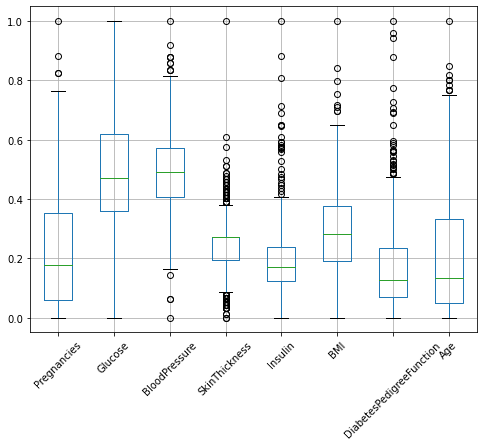

In [225]:
minmax.boxplot(figsize = (8,6), rot = 45)
plt.show()

#### StandardScaler

Standardization is a useful technique to transform attributes with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.

In [226]:
# Expresses in terms of number of standard deviations and mean zero. Commonly used. Outliers not such a problem
scaler = StandardScaler()
standard = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
standard.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,2.544261e-17,7.661695e-18,6.966722e-16,3.850725e-17,4.119968e-17,4.803738e-16,2.398978e-16,1.857600e-16
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-2.552931e+00,-4.004245e+00,-2.589294e+00,-1.743642e+00,-2.074100e+00,-1.189553e+00,-1.041549e+00
25%,-8.448851e-01,-7.201630e-01,-6.953060e-01,-5.624310e-01,-6.468694e-01,-7.205635e-01,-6.889685e-01,-7.862862e-01
50%,-2.509521e-01,-1.530732e-01,-1.675912e-02,2.257935e-01,-2.235283e-01,-6.562636e-02,-3.001282e-01,-3.608474e-01
75%,6.399473e-01,6.112653e-01,6.282695e-01,2.257935e-01,3.813170e-01,6.038649e-01,4.662269e-01,6.602056e-01
max,3.906578e+00,2.542658e+00,4.102655e+00,7.770228e+00,7.135692e+00,5.042883e+00,5.883565e+00,4.063716e+00


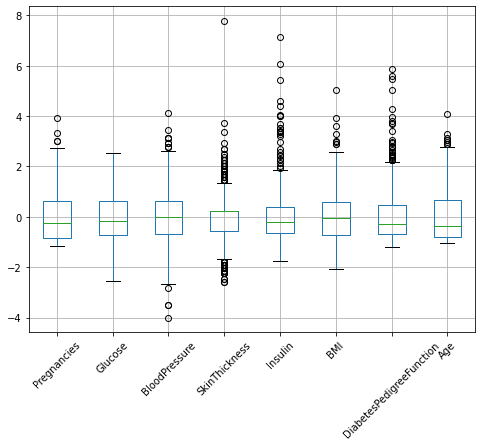

In [227]:
standard.boxplot(figsize = (8,6), rot = 45)
plt.show()

#### L1 Norm

In [203]:
# Normalisation - convert to unit norms (eg l1 norm)
normalizer = Normalizer(norm = 'l1')
norms = pd.DataFrame(normalizer.fit_transform(X),columns = X.columns)
norms.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.008783,0.277573,0.172123,0.070320,0.316056,0.076590,0.001112,0.077247
std,0.007640,0.041135,0.044909,0.023075,0.102874,0.020457,0.000791,0.025737
min,0.000000,0.135758,0.049648,0.010969,-0.074916,0.024907,0.000140,0.022036
25%,0.002830,0.254690,0.143208,0.054114,0.253162,0.062672,0.000547,0.059637
50%,0.007020,0.273784,0.167992,0.068402,0.313873,0.074705,0.000884,0.073537
75%,0.012958,0.297115,0.201648,0.083885,0.378071,0.088527,0.001456,0.090728
max,0.041208,0.447460,0.340415,0.166877,0.700043,0.161056,0.005737,0.252305


In [205]:
# Look at one row
norms.iloc[0]

Pregnancies                 0.010633
Glucose                     0.262293
BloodPressure               0.127602
SkinThickness               0.062029
Insulin                     0.388172
BMI                         0.059548
DiabetesPedigreeFunction    0.001111
Age                         0.088612
Name: 0, dtype: float64

In [206]:
# Sum the absolute values. Sum to one using l1 norm. Can also use the l2 norm.
norms.iloc[0].abs().sum()

1.0000000000000002

#### L2 Norm

In [228]:
# Normalisation - convert to unit norms (eg l1 norm)
normalizer = Normalizer(norm = 'l2')
norms2 = pd.DataFrame(normalizer.fit_transform(X),columns = X.columns)

In [229]:
# Sum the squares of the features will sum to one with l2 norm
norms2.iloc[0].pow(2).sum()

1.0

#### Max Norm

In [230]:
# Normalisation - convert to max norms (one feature is expressed as one and every other is expressed with reference to it)
normalizer = Normalizer(norm = 'max')
norms3 = pd.DataFrame(normalizer.fit_transform(X),columns = X.columns)
norms3.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.027394,0.675711,0.328724,0.159797,1.000000,0.153405,0.002863,0.228281
1,0.011765,1.000000,0.776471,0.341176,0.827548,0.312941,0.004129,0.364706
2,0.029567,0.676342,0.236535,0.118267,1.000000,0.086113,0.002484,0.118267
3,0.010638,0.946809,0.702128,0.244681,1.000000,0.298936,0.001777,0.223404
4,0.000000,0.815476,0.238095,0.208333,1.000000,0.256548,0.013619,0.196429


### Binarizer

In [217]:
# Convert to binary form (1 is above average and zero is below average)
binarizer = Binarizer(threshold = float((X[["Pregnancies"]].mean())))
binarized = pd.DataFrame(binarizer.fit_transform(X), columns = X.columns)
binarized.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.0,768.0,768.0,768.000000,768.0,768.0,768.0
mean,0.447917,1.0,1.0,1.0,0.998698,1.0,0.0,1.0
std,0.497604,0.0,0.0,0.0,0.036084,0.0,0.0,0.0
min,0.000000,1.0,1.0,1.0,0.000000,1.0,0.0,1.0
25%,0.000000,1.0,1.0,1.0,1.000000,1.0,0.0,1.0
50%,0.000000,1.0,1.0,1.0,1.000000,1.0,0.0,1.0
75%,1.000000,1.0,1.0,1.0,1.000000,1.0,0.0,1.0
max,1.000000,1.0,1.0,1.0,1.000000,1.0,0.0,1.0


In [219]:
# Apply to all columns
for i in range(1, X.shape[1]):
    
    scaler = Binarizer(threshold=float((X[[X.columns[i]]]).mean())). \
                                        fit(X[[X.columns[i]]])

    new_binarized_feature = scaler.transform(X[[X.columns[i]]])
    
    binarized_features = np.concatenate((binarized, new_binarized_feature), axis=1)

In [222]:
def build_model(X, Y, test_frac):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_frac)
    
    model = LogisticRegression(solver='liblinear').fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    print("Test_score : ", accuracy_score(y_test, y_pred))

In [237]:
# Compare each scaling method using the Logistic Regression model
build_model(minmax,y,0.2)
build_model(standard,y, 0.2)
build_model(norms,y,0.2)
build_model(norms2,y, 0.2)
build_model(norms3,y,0.2)
build_model(binarized,y,0.2)

Test_score :  0.7467532467532467
Test_score :  0.7987012987012987
Test_score :  0.6558441558441559
Test_score :  0.7077922077922078
Test_score :  0.7402597402597403
Test_score :  0.6428571428571429


# Categorical data transforms

## Sales Dataset

In [267]:
data = pd.read_csv("GoSales_Tx_LogisticRegression.csv")
data.head()

,IS_TENT,GENDER,AGE,MARITAL_STATUS,PROFESSION
0,False,M,27,Single,Professional
1,False,F,39,Married,Other
2,False,F,39,Married,Other
3,False,F,56,Unspecified,Hospitality
4,False,M,45,Married,Retired


In [268]:
data.shape

(60252, 5)

In [269]:
data.describe()

,AGE
count,60252.000000
mean,34.187479
std,10.105477
min,17.000000
25%,26.000000
50%,33.000000
75%,41.000000
max,69.000000


In [270]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60252 entries, 0 to 60251
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   IS_TENT         60252 non-null  bool  
 1   GENDER          60252 non-null  object
 2   AGE             60252 non-null  int64 
 3   MARITAL_STATUS  60252 non-null  object
 4   PROFESSION      60252 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 1.9+ MB


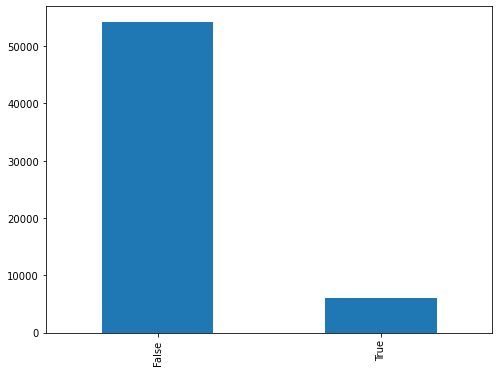

In [271]:
# People who buy a tent
plt.figure(figsize=(8,6))
pd.value_counts(data['IS_TENT']).plot.bar()
plt.show()

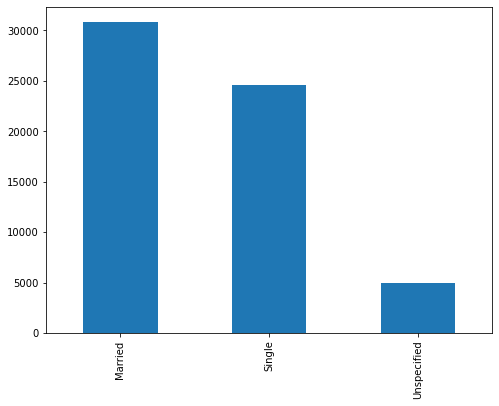

In [272]:
# Marital Status
plt.figure(figsize=(8,6))
pd.value_counts(data['MARITAL_STATUS']).plot.bar()
plt.show()

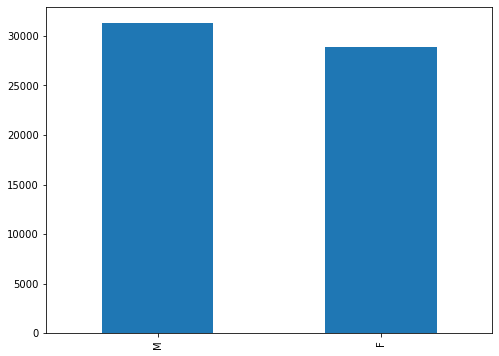

In [273]:
# Gender
plt.figure(figsize=(8, 6))
pd.value_counts(data['GENDER']).plot.bar()
plt.show()

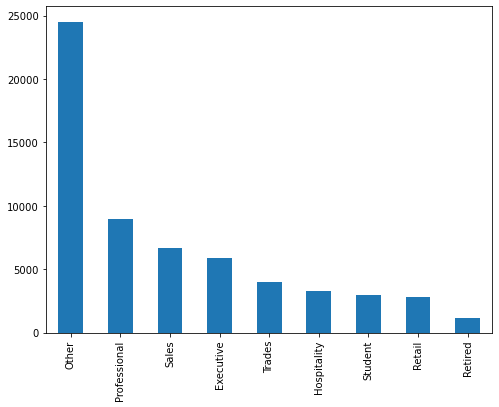

In [274]:
# Profession
plt.figure(figsize=(8, 6))
pd.value_counts(data['PROFESSION']).plot.bar()
plt.show()

### Label Encoder

In [275]:
# Label encode the gender column
gender = ['M','F']
label_encode = LabelEncoder()
label_encoded = label_encode.fit(gender)
data['GENDER'] = label_encoded.transform(data['GENDER'].astype(str))
data.head()

,IS_TENT,GENDER,AGE,MARITAL_STATUS,PROFESSION
0,False,1,27,Single,Professional
1,False,0,39,Married,Other
2,False,0,39,Married,Other
3,False,0,56,Unspecified,Hospitality
4,False,1,45,Married,Retired


### One-hot Encoding

In [280]:
# One-hot encode the marital status column
one_hot_encoding = OneHotEncoder()
one_hot_encoded = one_hot_encoding.fit(data['MARITAL_STATUS'].values.reshape(-1, 1))
one_hot_labels = one_hot_encoding.transform(data['MARITAL_STATUS'].values.reshape(-1, 1)).toarray()

In [282]:
one_hot_encoding.categories_

[array(['Married', 'Single', 'Unspecified'], dtype=object)]

In [281]:
one_hot_labels[0:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [283]:
# Create a dataframe from the one hot labels
labels_df = pd.DataFrame()
labels_df['MARITAL_STATUS_Married'] = one_hot_labels[:,0]
labels_df['MARITAL_STATUS_Single'] = one_hot_labels[:,1]
labels_df['MARITAL_STATUS_Unspecified'] = one_hot_labels[:,2]
labels_df.head(10)

,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Unspecified
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


In [284]:
# Concate to the original dataframe and drop the original marital status column
encoded_df = pd.concat([data, labels_df], axis=1)
encoded_df.drop('MARITAL_STATUS', axis=1, inplace=True)

In [287]:
encoded_df.head()

,IS_TENT,GENDER,AGE,PROFESSION,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Unspecified
0,False,1,27,Professional,0.0,1.0,0.0
1,False,0,39,Other,1.0,0.0,0.0
2,False,0,39,Other,1.0,0.0,0.0
3,False,0,56,Hospitality,0.0,0.0,1.0
4,False,1,45,Retired,1.0,0.0,0.0


### Alternative - use Pandas get dummies function

In [288]:
data = pd.get_dummies(encoded_df, columns=['PROFESSION'])
data.head()

,IS_TENT,GENDER,AGE,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Unspecified,PROFESSION_Executive,PROFESSION_Hospitality,PROFESSION_Other,PROFESSION_Professional,PROFESSION_Retail,PROFESSION_Retired,PROFESSION_Sales,PROFESSION_Student,PROFESSION_Trades
0,False,1,27,0.0,1.0,0.0,0,0,0,1,0,0,0,0,0
1,False,0,39,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0
2,False,0,39,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0
3,False,0,56,0.0,0.0,1.0,0,1,0,0,0,0,0,0,0
4,False,1,45,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0


In [290]:
# Re-load the data and use the get dummies function on all the categorical columns in the dataframe
data = pd.read_csv("GoSales_Tx_LogisticRegression.csv")
data = pd.get_dummies(data)
data.head()

,IS_TENT,AGE,GENDER_F,GENDER_M,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Unspecified,PROFESSION_Executive,PROFESSION_Hospitality,PROFESSION_Other,PROFESSION_Professional,PROFESSION_Retail,PROFESSION_Retired,PROFESSION_Sales,PROFESSION_Student,PROFESSION_Trades
0,False,27,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,False,39,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,False,39,1,0,1,0,0,0,0,1,0,0,0,0,0,0
3,False,56,1,0,0,0,1,0,1,0,0,0,0,0,0,0
4,False,45,0,1,1,0,0,0,0,0,0,0,1,0,0,0


## Discretization Examples

Convert continuous values to categorical values

In [291]:
# Example array using pandas cut to discretize values into 4 bins
X = np.array([-7, 2, -3, -11, 14, 6, 8])
categories = pd.cut(X, 4)
categories

[(-11.025, -4.75], (1.5, 7.75], (-4.75, 1.5], (-11.025, -4.75], (7.75, 14.0], (1.5, 7.75], (7.75, 14.0]]
Categories (4, interval[float64]): [(-11.025, -4.75] < (-4.75, 1.5] < (1.5, 7.75] < (7.75, 14.0]]

In [292]:
# Shows the bins start and end points, the second number is up to and including
categories.categories

IntervalIndex([(-11.025, -4.75], (-4.75, 1.5], (1.5, 7.75], (7.75, 14.0]],
              closed='right',
              dtype='interval[float64]')

In [293]:
# This shows the bins that each number has been placed into
categories.codes

array([0, 2, 1, 0, 3, 2, 3], dtype=int8)

In [294]:
# Shows that the categories are ordered
categories.ordered

True

In [295]:
# Return the bins
pd.cut(X, 4, retbins=True)

([(-11.025, -4.75], (1.5, 7.75], (-4.75, 1.5], (-11.025, -4.75], (7.75, 14.0], (1.5, 7.75], (7.75, 14.0]]
 Categories (4, interval[float64]): [(-11.025, -4.75] < (-4.75, 1.5] < (1.5, 7.75] < (7.75, 14.0]],
 array([-11.025,  -4.75 ,   1.5  ,   7.75 ,  14.   ]))

In [297]:
# Another example where the bins are specified
marks = np.array([70, 20, 30, 99, 40, 16, 80])
categories, bins = pd.cut(marks, 4, retbins=True, labels=['poor', 'average', 'good', 'excellent'])

In [298]:
categories.categories

Index(['poor', 'average', 'good', 'excellent'], dtype='object')

In [300]:
bins

array([15.917, 36.75 , 57.5  , 78.25 , 99.   ])

In [301]:
# Create series of the data with specified index
df = pd.Series(marks, index = [1, 2, 3, 4, 5, 6, 7])
df

1    70
2    20
3    30
4    99
5    40
6    16
7    80
dtype: int32

In [303]:
# Shows the bins by index for each mark
categories, bins = pd.cut(df, 4, retbins=True)
categories

1      (57.5, 78.25]
2    (15.917, 36.75]
3    (15.917, 36.75]
4      (78.25, 99.0]
5      (36.75, 57.5]
6    (15.917, 36.75]
7      (78.25, 99.0]
dtype: category
Categories (4, interval[float64]): [(15.917, 36.75] < (36.75, 57.5] < (57.5, 78.25] < (78.25, 99.0]]

In [304]:
bins

array([15.917, 36.75 , 57.5  , 78.25 , 99.   ])

In [306]:
# Using the KBinsDiscretizer - each feature has the same width
marks = [[70], [20], [30], [99], [40], [16], [80]]
enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
enc.fit(marks)
enc.transform(marks)

array([[2.],
       [0.],
       [0.],
       [3.],
       [1.],
       [0.],
       [3.]])

In [307]:
enc.bin_edges_

array([array([16.  , 36.75, 57.5 , 78.25, 99.  ])], dtype=object)

In [308]:
# Another example with a different strategy
X = [[-21, 41, -14],
     [-13, 23, -31],
     [  9, 30, -5],
     [  0, 24, -17]]

In [309]:
enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
enc.fit(X)
X_trans = enc.transform(X)
X_trans

array([[0., 3., 2.],
       [1., 0., 0.],
       [3., 2., 3.],
       [2., 1., 1.]])

In [310]:
enc.bin_edges_

array([array([-21.  , -15.  ,  -6.5 ,   2.25,   9.  ]),
       array([23.  , 23.75, 27.  , 32.75, 41.  ]),
       array([-31.  , -20.5 , -15.5 , -11.75,  -5.  ])], dtype=object)

In [311]:
# Inverse transform will return the mean of the bin
enc.inverse_transform(X_trans)

array([[-18.   ,  36.875, -13.625],
       [-10.75 ,  23.375, -25.75 ],
       [  5.625,  29.875,  -8.375],
       [ -2.125,  25.375, -18.   ]])

### Regression Example Comparing Discretized and Non-Discretized Data

In [328]:
automobile_df = pd.read_csv('cars.csv')
automobile_df.head(10)

,Model,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,bore,stroke,compression-ratio
0,chevrolet chevelle malibu,18.0,8,307,130,3504,12,1970[1975],"US; Detroit, Michigan",3.47,2.68,9
1,buick skylark 320,15.0,8,350,165,3693,11.5,1970,US],3.47,2.68,?
2,plymouth satellite,18.0,?,318,150,3436,11,"1970, 1976",US,2.68,3.47,9
3,amc rebel sst,16.0,8,304,150,3433,12,1970,US,3.19,3.40,10
4,ford torino,17.0,8,302,140,3449,10.5,1970-1972,US],3.19,3.40,8
5,ford galaxie 500,15.0,8,?,198,4341,10,1970,US,3.19,3.40,8.5
6,chevrolet impala,14.0,8,454,220,4354,9,1970[1975],"US; Detroit, Michigan",3.19,3.40,8.5
7,plymouth fury iii,NaN,8,440,215,4312,8.5,1970,US,3.19,3.40,8.5
8,pontiac catalina,14.0,8,455,225,4425,8.5,1970,US,3.13,3.40,8.3
9,amc ambassador dpl,15.0,8,390,190,3850,8.5,1970,US],3.13,3.40,7


In [372]:
automobile_df = automobile_df.dropna()

In [373]:
# Set the label as MPG and the feature as Horsepower
X = automobile_df[['Horsepower']]
y = automobile_df['MPG']

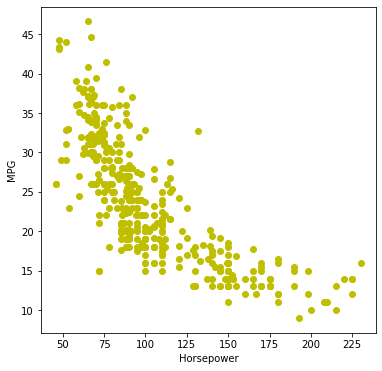

In [374]:
# Plot the relationship between the two variables
plt.figure(figsize=(6,6))
plt.plot(X,y, 'o', c='y')
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.show()

#### Non-discretized data

In [375]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [376]:
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("r_2 score: ", r2_score(y_test, y_pred))

r_2 score:  0.5120531480335656


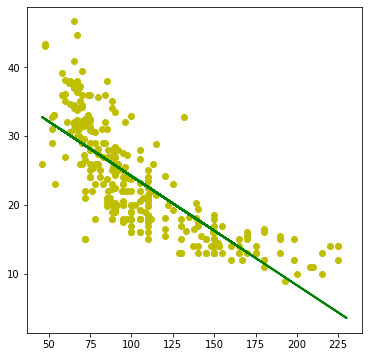

In [377]:
plt.figure(figsize=(6,6))
plt.plot(x_train, y_train, 'o', c='y')
plt.plot(x_test, y_pred, linewidth=2, color='green',
         linestyle='-', label='linear regression')
plt.show()

#### Discretized data

Encoding - ordinal

In [378]:
enc = KBinsDiscretizer(n_bins=20, encode='ordinal')
x_binned = enc.fit_transform(x_train)
x_test_binned = enc.transform(x_test)
reg = LinearRegression().fit(x_binned, y_train)
y_pred = reg.predict(x_test_binned)
r2_score(y_test, y_pred)

0.6099751834843135

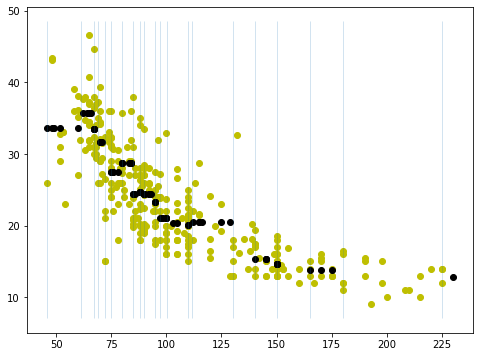

In [383]:
plt.figure(figsize=(8,6))
plt.scatter(x_train, y_train, c='y')
plt.scatter(x_test, y_pred, color='k')
plt.vlines(enc.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=.2)
plt.show()

Encoding - one-hot and strategy is quantile by default

In [380]:
enc = KBinsDiscretizer(n_bins=20, encode='onehot')
x_binned = enc.fit_transform(x_train)
x_test_binned = enc.transform(x_test)
reg = LinearRegression().fit(x_binned, y_train)
y_pred = reg.predict(x_test_binned)
r2_score(y_test, y_pred)

0.6236417870515032

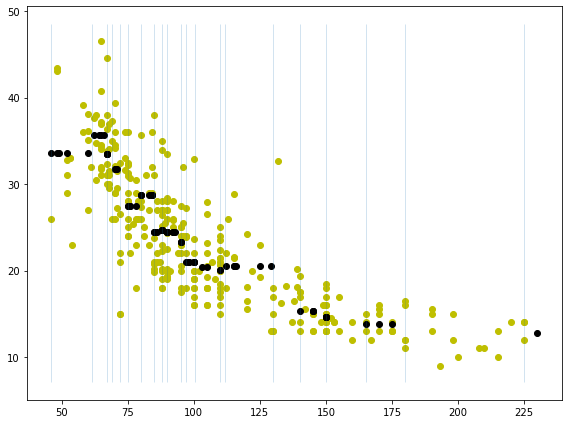

In [384]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, c='y')
plt.scatter(x_test, y_pred, color='k')
plt.vlines(enc.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=.2)
plt.tight_layout()

Discretizing improves the predictive power of the model

# Feature Selection

## Feature Correlations

In [387]:
# Using yellowbrick diagnostic tools
diabetes = pd.read_csv("diabetes.csv")
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


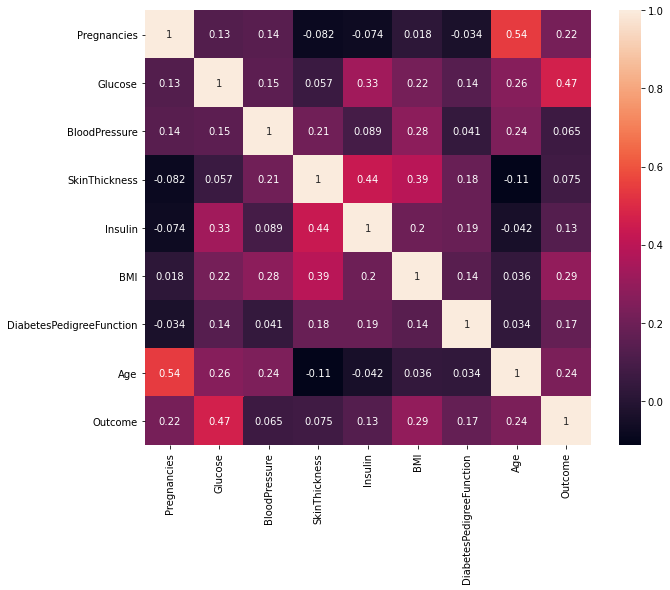

In [391]:
# Have a look at the correlations with a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(diabetes_corr, annot=True)
plt.show()

In [392]:
X = diabetes[['Insulin', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction']]
Y = diabetes['Age']
feature_names = X.columns

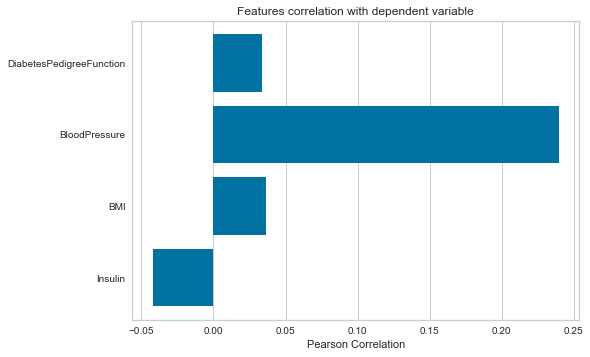

In [398]:
from yellowbrick.target import FeatureCorrelation
visualizer = FeatureCorrelation(labels=feature_names, method='pearson')
visualizer.fit(X, Y)
visualizer.poof()
plt.show()

In [396]:
visualizer.scores_

array([-0.04216295,  0.03624187,  0.23952795,  0.03356131])

In [397]:
score_df = pd.DataFrame({'Feature_names' : visualizer.features_,
                         'Scores' : visualizer.scores_})
score_df

,Feature_names,Scores
0,Insulin,-0.042163
1,BMI,0.036242
2,BloodPressure,0.239528
3,DiabetesPedigreeFunction,0.033561


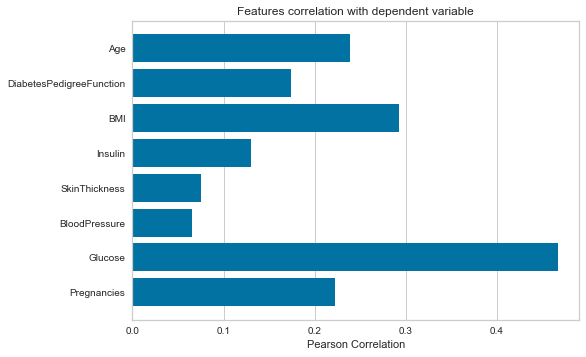

In [399]:
X = diabetes.drop('Outcome', axis=1)
Y = diabetes['Outcome']
feature_names = X.columns
visualizer = FeatureCorrelation(labels=feature_names, method='pearson')
visualizer.fit(X, Y)
visualizer.poof()
plt.show()

In [400]:
visualizer.scores_

array([0.22189815, 0.4665814 , 0.06506836, 0.07475223, 0.13054795,
       0.29269466, 0.17384407, 0.23835598])

In [401]:
visualizer.features_

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)

In [402]:
score_df = pd.DataFrame({'Feature_names' : visualizer.features_,
                         'Scores' : visualizer.scores_})
score_df

,Feature_names,Scores
0,Pregnancies,0.221898
1,Glucose,0.466581
2,BloodPressure,0.065068
3,SkinThickness,0.074752
4,Insulin,0.130548
5,BMI,0.292695
6,DiabetesPedigreeFunction,0.173844
7,Age,0.238356


### Mutual information classification

Measurs the dependency between two variables. If the two variables are independent the mutual information will be zero and if they are not then the value will be greater than zero. Tries to find out information about one random variable by observing the other random variable.

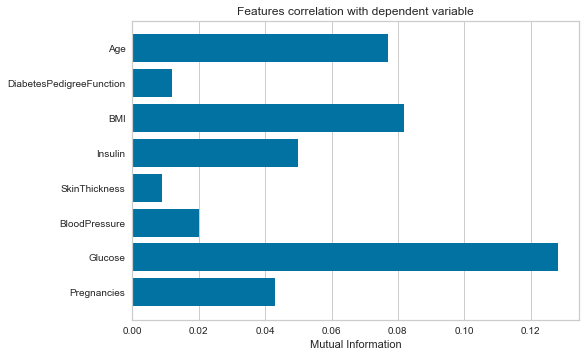

In [404]:
# Set all variables to false and pregnancy to true as a discrete variable. Need to say which variables are discrete
discrete_features = [False for _ in range(len(feature_names))]
discrete_features[0] = True

visualizer = FeatureCorrelation(method='mutual_info-classification',
                                labels=feature_names)

visualizer.fit(X, Y, discrete_features=discrete_features, random_state=0)

visualizer.poof()
plt.show()

All variables are positively related to outcome

In [407]:
score_df = pd.DataFrame({'Feature_names' : visualizer.features_,
                         'Scores' : visualizer.scores_})
score_df

,Feature_names,Scores
0,Age,0.046833
1,BMI,0.071820
2,Insulin,0.035542
3,BloodPressure,0.003267
4,Glucose,0.126805


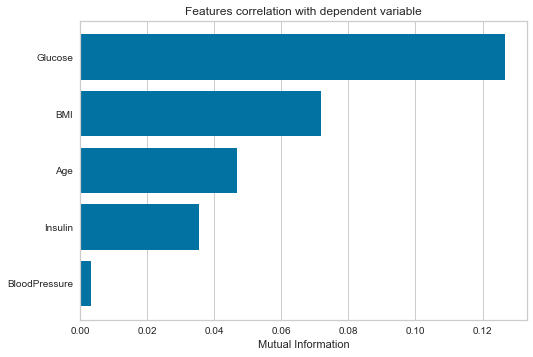

In [412]:
feature_to_plot = ['Age', 'BMI', 'Insulin', 'BloodPressure', 'Glucose']
visualizer = FeatureCorrelation(method='mutual_info-classification',
                                feature_names=feature_to_plot, sort=True)

visualizer.fit(X, Y, random_state=0)
visualizer.poof()
plt.show()

In [413]:
score_df = pd.DataFrame({'Feature_names' : visualizer.features_,
                         'Scores' : visualizer.scores_})

score_df

,Feature_names,Scores
0,BloodPressure,0.003267
1,Insulin,0.035542
2,Age,0.046833
3,BMI,0.071820
4,Glucose,0.126805


### Multicollinearity

In [419]:
automobile = pd.read_csv('auto_mpg_processed.csv')
automobile.head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Origin,age
0,18.0,8,307.0,130,3504,307.0,US,49
1,16.0,8,304.0,150,3433,304.0,US,49


In [422]:
# Scale each column to centre around mean zero
from sklearn import preprocessing
automobile[['Cylinders']] = preprocessing.scale(automobile[['Cylinders']].astype('float64'))
automobile[['Displacement']] = preprocessing.scale(automobile[['Displacement']].astype('float64'))
automobile[['Horsepower']] = preprocessing.scale(automobile[['Horsepower']].astype('float64'))
automobile[['Weight']] = preprocessing.scale(automobile[['Weight']].astype('float64'))
automobile[['Acceleration']] = preprocessing.scale(automobile[['Acceleration']].astype('float64'))
automobile[['age']] = preprocessing.scale(automobile[['age']].astype('float64'))

In [424]:
automobile.head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Origin,age
0,18.0,1.554447,1.108580,0.692081,0.637231,1.108580,US,1.660135
1,16.0,1.554447,1.079614,1.217300,0.553231,1.079614,US,1.660135


In [438]:
# Regression analysis (dropping origin but can one-hot encode and include them if wanted)
X = automobile.drop(['MPG', 'Origin'], axis=1)
Y = automobile['MPG']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
linear_model = LinearRegression(normalize=True).fit(x_train, y_train)
print("Training_score : " , linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)
print("Testing_score : ", r2_score(y_test, y_pred))

Training_score :  0.7904957684875885
Testing_score :  0.7736900319722984


In [426]:
# Adjusted r2 score to account for lots of features (adjusted for number of predictors)
def adjusted_r2(r_square, labels, features):
    adj_r_square = 1 - ((1 - r_square) * (len(labels) - 1)) / (len(labels) - features.shape[1] - 1)
    return adj_r_square

In [427]:
# Run the function
print("Adjusted_r2_score : ", adjusted_r2(r2_score(y_test, y_pred), y_test, x_test))

Adjusted_r2_score :  0.8008243972457721


In [428]:
# Correlation matrix
features_corr = X.corr()
features_corr

,Cylinders,Displacement,Horsepower,Weight,Acceleration,age
Cylinders,1.000000,0.922633,0.811466,0.873029,0.922633,0.321850
Displacement,0.922633,1.000000,0.894199,0.932822,1.000000,0.357047
Horsepower,0.811466,0.894199,1.000000,0.863388,0.894199,0.404458
Weight,0.873029,0.932822,0.863388,1.000000,0.932822,0.299049
Acceleration,0.922633,1.000000,0.894199,0.932822,1.000000,0.357047
age,0.321850,0.357047,0.404458,0.299049,0.357047,1.000000


In [429]:
# Find those with high correlation
abs(features_corr) > 0.8

,Cylinders,Displacement,Horsepower,Weight,Acceleration,age
Cylinders,True,True,True,True,True,False
Displacement,True,True,True,True,True,False
Horsepower,True,True,True,True,True,False
Weight,True,True,True,True,True,False
Acceleration,True,True,True,True,True,False
age,False,False,False,False,False,True


In [430]:
# Drop those with high correlation between them (indicates multicollinearity)
trimmed_features_df = X.drop(['Cylinders', 'Displacement', 'Weight'], axis=1)
trimmed_features_corr = trimmed_features_df.corr()
trimmed_features_corr

,Horsepower,Acceleration,age
Horsepower,1.000000,0.894199,0.404458
Acceleration,0.894199,1.000000,0.357047
age,0.404458,0.357047,1.000000


In [431]:
abs(trimmed_features_corr) > 0.8

,Horsepower,Acceleration,age
Horsepower,True,True,False
Acceleration,True,True,False
age,False,False,True


### Variance Inflation Factor

Alternative technique to select non-collinearity features. Can be calculated with statsmodels library. Compares variance for feature i relative to all other features.

* 1 = not correlated.
* Between 1 and 5 = moderately correlated.
* Greater than 5 = highly correlated

In [439]:
# Variance inflation
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(2)

C:\Users\imoge\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,6.84,Cylinders
1,inf,Displacement
2,5.49,Horsepower
3,8.22,Weight
4,inf,Acceleration
5,1.22,age


In [440]:
X = X.drop(['Displacement', 'Weight'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(2)

,VIF Factor,features
0,6.76,Cylinders
1,5.24,Horsepower
2,11.53,Acceleration
3,1.20,age


In [441]:
# Drop those features displaying multicollinearity then run linear model
X = automobile.drop(['MPG', 'Displacement', 'Weight', 'Origin'], axis=1)
Y = automobile['MPG']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
linear_model = LinearRegression(normalize=True).fit(x_train, y_train)
print("Training_score : " , linear_model.score(x_train, y_train))
y_pred = linear_model.predict(x_test)
print("Testing_score : ", r2_score(y_test, y_pred))
print("Adjusted_r2_score : ", adjusted_r2(r2_score(y_test, y_pred), y_test, x_test))

Training_score :  0.7033551317953879
Testing_score :  0.7789847750798651
Adjusted_r2_score :  0.76687435179657


## Using Missing Values and Variance Thresholds to Select Features

In [444]:
diabetes_data = pd.read_csv('diabetes.csv')
diabetes_data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [445]:
# Replace zero values with nan as before
diabetes_data['Glucose'].replace(0, np.nan, inplace= True)
diabetes_data['BloodPressure'].replace(0, np.nan, inplace= True)
diabetes_data['SkinThickness'].replace(0, np.nan, inplace= True)
diabetes_data['Insulin'].replace(0, np.nan, inplace= True)
diabetes_data['BMI'].replace(0, np.nan, inplace= True)

In [446]:
diabetes_data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [448]:
# Find the percentage of missing data for each feature
print(diabetes_data['Glucose'].isnull().sum() / len(diabetes_data) * 100)
print(diabetes_data['BloodPressure'].isnull().sum() / len(diabetes_data) *100)
print(diabetes_data['SkinThickness'].isnull().sum() / len(diabetes_data) * 100)
print(diabetes_data['Insulin'].isnull().sum() / len(diabetes_data) * 100)
print(diabetes_data['BMI'].isnull().sum() / len(diabetes_data) * 100)

0.6510416666666667
4.557291666666666
29.557291666666668
48.69791666666667
1.4322916666666665


In [449]:
# Drop columns with missing values which are beyond a specified threshold. Here keep only those columns with less than 10% missing
diabetes_data_trimmed = diabetes_data.dropna(thresh=int(diabetes_data.shape[0] * .9), axis=1)
diabetes_data_trimmed.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [450]:
# Read in the pre-processed dataframe where imputation was used for missing values
diabetes_data = pd.read_csv('diabetes_processed.csv')
diabetes_data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,219.028414,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,70.341550,26.6,0.351,31.0,0


In [451]:
# Examine the variance of the features before scaling
X = diabetes_data.drop('Outcome', axis = 1)
Y = diabetes_data['Outcome']
X.var(axis=0)

Pregnancies                   11.354056
Glucose                      926.489244
BloodPressure                146.321591
SkinThickness                 78.969986
Insulin                     9449.130490
BMI                           47.270664
DiabetesPedigreeFunction       0.109779
Age                          138.303046
dtype: float64

In [452]:
# Scale the values and examine the variance after scaling. Low variance does not contain much predictive power
from sklearn.preprocessing import minmax_scale
X_scaled = pd.DataFrame(minmax_scale(X, feature_range=(0, 10)), columns=X.columns)
X_scaled.var()

Pregnancies                 3.928739
Glucose                     3.856355
BloodPressure               1.523548
SkinThickness               0.933010
Insulin                     1.270004
BMI                         1.976851
DiabetesPedigreeFunction    2.001447
Age                         3.841751
dtype: float64

In [455]:
# High variance - more predictive power? Can then use variance threshold to choose features to work with 
from sklearn.feature_selection import VarianceThreshold
select_features = VarianceThreshold(threshold = 1.0)
X_new = select_features.fit_transform(X_scaled)
var_df = pd.DataFrame({'feature names' : list(X_scaled),
                       'variances' : select_features.variances_
                      })
var_df

,feature names,variances
0,Pregnancies,3.923624
1,Glucose,3.851334
2,BloodPressure,1.521565
3,SkinThickness,0.931795
4,Insulin,1.268350
5,BMI,1.974277
6,DiabetesPedigreeFunction,1.998841
7,Age,3.836749


In [459]:
# New features with skin thickness dropped. Find which features are which
X_new = pd.DataFrame(X_new)
selected_features = []

for i in range(len(X_new.columns)):
    for j in range(len(X_scaled.columns)):

        if(X_new.iloc[:,i].equals(X_scaled.iloc[:,j])):
            selected_features.append(X_scaled.columns[j])
            
selected_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

## Univariate Statistical Feature Selection

In [461]:
# Bring in the unprocessed dataset again and use a helper function to select features from unscaled and scaled features
# from the previous section

diabetes_data = pd.read_csv('diabetes.csv')
def get_selected_features(X, X_new):
    selected_features = []

    for i in range(len(X_new.columns)):
        for j in range(len(X.columns)):

            if(X_new.iloc[:,i].equals(X.iloc[:,j])):
                print(X.columns[j])
                selected_features.append(X.columns[j])

    return selected_features

In [462]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
X = diabetes_data.drop('Outcome', axis=1)
Y = diabetes_data['Outcome']
X = X.astype(np.float64)
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)
fit.scores_

array([ 111.51969064, 1411.88704064,   17.60537322,   53.10803984,
       2175.56527292,  127.66934333,    5.39268155,  181.30368904])

In [463]:
feature_score = pd.DataFrame()

for i in range(X.shape[1]):
    new = pd.DataFrame({'Features' : X.columns[i],
                        'Score' : fit.scores_[i]}, index=[i])
    
    feature_score = pd.concat([feature_score, new])

In [464]:
feature_score

,Features,Score
0,Pregnancies,111.519691
1,Glucose,1411.887041
2,BloodPressure,17.605373
3,SkinThickness,53.108040
4,Insulin,2175.565273
5,BMI,127.669343
6,DiabetesPedigreeFunction,5.392682
7,Age,181.303689


In [465]:
X_new = fit.transform(X)
X_new = pd.DataFrame(X_new)
selected_features = get_selected_features(X, X_new)

Glucose
Insulin
BMI
Age


In [467]:
X_new.head()

,0,1,2,3
0,148.0,0.0,33.6,50.0
1,85.0,0.0,26.6,31.0
2,183.0,0.0,23.3,32.0
3,89.0,94.0,28.1,21.0
4,137.0,168.0,43.1,33.0


### ANOVA F_score

In [469]:
chi2_best_features = X[selected_features]
from sklearn.feature_selection import f_classif, SelectPercentile
test = SelectPercentile(f_classif, percentile=80)
fit = test.fit(X, Y)
fit.scores_

array([ 39.67022739, 213.16175218,   3.2569504 ,   4.30438091,
        13.28110753,  71.7720721 ,  23.8713002 ,  46.14061124])

In [471]:
X_new = fit.transform(X)
X_new = pd.DataFrame(X_new)
selected_features = get_selected_features(X, X_new)
selected_features

Pregnancies
Glucose
Insulin
BMI
DiabetesPedigreeFunction
Age


['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [472]:
X[selected_features].head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,0.0,33.6,0.627,50.0
1,1.0,85.0,0.0,26.6,0.351,31.0
2,8.0,183.0,0.0,23.3,0.672,32.0
3,1.0,89.0,94.0,28.1,0.167,21.0
4,0.0,137.0,168.0,43.1,2.288,33.0


In [473]:
f_classif_best_features = X[selected_features]

In [475]:
# Original features
build_model(X, Y, 0.2)

Test_score :  0.7792207792207793


In [476]:
# Four most significant features from chi-squared
build_model(chi2_best_features, Y, 0.2)

Test_score :  0.7597402597402597


In [477]:
# ANOVA selected features
build_model(f_classif_best_features, Y, 0.2)

Test_score :  0.7597402597402597


## Wrapper Methods

### Recursive Feature Elimination

In [484]:
from sklearn.feature_selection import RFE
model = LogisticRegression(solver='liblinear')
rfe = RFE(model, n_features_to_select=4)
fit = rfe.fit(X, Y)
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)

Num Features:  4
Selected Features:  [ True  True False False False  True  True False]
Feature Ranking:  [1 1 2 4 5 1 1 3]


In [492]:
feature_rank = pd.DataFrame({'columns': X.columns, 
                             'ranking': fit.ranking_, 
                             'selected': fit.support_})
feature_rank

,columns,ranking,selected
0,Pregnancies,1,True
1,Glucose,1,True
2,BloodPressure,2,False
3,SkinThickness,4,False
4,Insulin,5,False
5,BMI,1,True
6,DiabetesPedigreeFunction,1,True
7,Age,3,False


In [493]:
recursive_feature_names = feature_rank.loc[feature_rank['selected'] == True]
X[recursive_feature_names['columns'].values].head()
recursive_feature_names
recursive_features = X[recursive_feature_names['columns'].values]

### Forward Stepwise Elimination

In [494]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

In [500]:
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=10),
                                             k_features=4,
                                             forward=True,
                                             scoring='accuracy',
                                             cv=4)

features = feature_selector.fit(np.array(X), Y)
forward_elimination_feature_names = list(X.columns[list(features.k_feature_idx_)])
forward_elimination_features = X[forward_elimination_feature_names]
forward_elimination_feature_names

['Glucose', 'BloodPressure', 'BMI', 'Age']

### Backward Elimination

In [501]:
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=10),
                                             k_features=4,
                                             forward=False,
                                             scoring='accuracy',
                                             cv=4)

features = feature_selector.fit(np.array(X), Y)
back_elimination_feature_names = list(X.columns[list(features.k_feature_idx_)])
back_elimination_features = X[back_elimination_feature_names]
back_elimination_feature_names 

['Glucose', 'BloodPressure', 'Insulin', 'BMI']

In [502]:
# Model using all features
build_model(X, Y, 0.2)

Test_score :  0.7532467532467533


In [503]:
# Using four recursive features
build_model(recursive_features, Y, 0.2)

Test_score :  0.7272727272727273


In [504]:
# Using features from forward elimination
build_model(forward_elimination_features, Y, 0.2)

Test_score :  0.7207792207792207


In [506]:
# Using features from backward elimination
build_model(back_elimination_features, Y, 0.2)

Test_score :  0.8181818181818182


## Embedding Methods

In [509]:
automobile = pd.read_csv('cars_processed.csv')
X = automobile.drop(['MPG', 'Origin'], axis=1)
Y = automobile['MPG']

### Lasso Method

In [510]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.8)
lasso.fit(X, Y)
predictors = X.columns
coef = pd.Series(lasso.coef_, predictors).sort_values()
print(coef)

Age            -0.673784
Weight         -0.006603
Horsepower     -0.004511
Cylinders      -0.000000
Acceleration    0.000000
Displacement    0.001366
dtype: float64


Forces less important features to tend to zero

In [511]:
# Pick out important features only
lasso_features = ['Age', 'Weight']
X[lasso_features].head()

,Age,Weight
0,49,3504
1,49,3433
2,49,3449
3,49,4354
4,49,4312


### Decision Tree Method

In [519]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor(max_depth=4)
decision_tree.fit(X,Y)
predictors = X.columns
coef = pd.Series(decision_tree.feature_importances_, predictors).sort_values()
print(coef)

Cylinders       0.000000
Acceleration    0.000000
Weight          0.064613
Age             0.112716
Horsepower      0.177081
Displacement    0.645590
dtype: float64


In [516]:
decision_tree_features = ['Displacement', 'Horsepower']
X[decision_tree_features].head()

,Displacement,Horsepower
0,307.0,130
1,304.0,150
2,302.0,140
3,454.0,220
4,440.0,215


In [520]:
def build_model(X, Y, test_frac):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_frac)
    
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    print("Test_score : ", r2_score(y_test, y_pred))

In [521]:
# Lasso model
build_model(X[lasso_features], Y, 0.2)

Test_score :  0.7954967777829696


In [522]:
# Decision tree model
build_model(X[decision_tree_features], Y, 0.2)

Test_score :  0.6748071968849407
